In [1]:
import sys
from pathlib import Path
ROOT = Path().resolve().parents[0]
sys.path.append(str(ROOT / "src"))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D

from scipy.stats import gaussian_kde
from scipy.stats import norm

plt.style.use("rotskoff_notebook.mplstyle")

In [2]:
MICROSTATES = ["PRN_prot", "PRN_deprot"]

INPUT_ROOT = ROOT / "data" / "microstates"
RESULTS_ROOT = ROOT / "results"

mm_file = np.load(
    RESULTS_ROOT / "mmresp_prn" / "charges.npz",  # adjust path if needed
    allow_pickle=True
)

mm_by_mol = mm_file["charges_final_by_mol"][()]        # dict: {"PRN_prot": array(...), ...}

hydro_dataset = {}; oxygen_dataset = {}; nitrogen_dataset = {}; carbon_dataset = {}

for state in MICROSTATES:
    base = RESULTS_ROOT / state

    labels        = np.load(base / "rawESP"      / "charges_constraint.npz", allow_pickle=True)["labels"].astype(str)
    esp_charges   = np.load(base / "rawESP"      / "charges_constraint.npz", allow_pickle=True)["charges"]
    tsresp_charges= np.load(base / "twostepRESP_basic" / "charges_constraint.npz", allow_pickle=True)["step2"]
    mcresp_charges= np.load(base / "multiconfRESP_reduced_masked_total" / "charges_final.npy", allow_pickle=True)

    # ---- build mmRESP charges aligned to *these* labels ----
    # mm_by_mol[state] is the mm charges in the same order as mm_labels
    mm_state_array = mm_by_mol[state]  # 1D array

    if len(mm_state_array) != len(labels):
        raise ValueError(f"Length mismatch for {state}: labels={len(labels)}, mm={len(mm_state_array)}")

    mmresp_charges = mm_state_array

    # masks
    mask_h = (np.char.startswith(labels, "H") & ~np.isin(labels, ["HA3"]))
    mask_o = np.char.startswith(labels, "O")
    mask_c = np.char.startswith(labels, "C")

    hydro_dataset[state] = {
        "labels":        labels[mask_h],
        "raw_charges":   esp_charges[mask_h],
        "tsresp_charges":tsresp_charges[mask_h],
        "mcresp_charges":mcresp_charges[mask_h],
        "mmresp_charges":mmresp_charges[mask_h],   # NEW
    }

    oxygen_dataset[state] = {
        "labels":        labels[mask_o],
        "raw_charges":   esp_charges[mask_o],
        "tsresp_charges":tsresp_charges[mask_o],
        "mcresp_charges":mcresp_charges[mask_o],
        "mmresp_charges":mmresp_charges[mask_o],   # NEW
    }

    carbon_dataset[state] = {
        "labels":        labels[mask_c],
        "raw_charges":   esp_charges[mask_c],
        "tsresp_charges":tsresp_charges[mask_c],
        "mcresp_charges":mcresp_charges[mask_c],
        "mmresp_charges":mmresp_charges[mask_c],   # NEW
    }


In [3]:
'''fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=False)
axes = axes.reshape(3, 2)

bins   = np.linspace(-1.2, 1.2, 50)
x_grid = np.linspace(bins[0], bins[-1], 400)

element_datasets = [hydro_dataset, oxygen_dataset, carbon_dataset]
row_titles       = ["Hydrogens", "Oxygens", "Carbons"]

row_cmaps = {
    "Hydrogens": plt.cm.Greens,
    "Oxygens":   plt.cm.Reds,
    "Carbons":   plt.cm.Blues,
}

microstate_labels = ['PRNH', r'PRN$^-$']

for row, (edata, row_title) in enumerate(zip(element_datasets, row_titles)):
    cmap = row_cmaps[row_title]

    for col, state in enumerate(MICROSTATES):   # ["PRN_prot", "PRN_deprot"]
        ax = axes[row, col]

        if row == 0:          # hydrogens
            ax.set_ylim(-3.5, 15)
        elif row == 1:        # oxygens
            ax.set_ylim(-3.5, 15)
        elif row == 2:        # carbons
            ax.set_ylim(-3.5, 15)

        labels      = edata[state]["labels"]
        raw_charges = edata[state]["raw_charges"]      # (n_atoms, n_frames)
        tsresp      = edata[state]["tsresp_charges"]   # (n_atoms, n_frames)
        mccharges = edata[state]["mcresp_charges"]

        n_atoms = len(labels)
        if n_atoms == 0:
            ax.axis("off")
            continue

        colors = cmap(np.linspace(0.35, 0.85, n_atoms))

        # microstate label (top right)
        pretty_label = microstate_labels[col]

        ax.text(
            0.98, 0.98, pretty_label,
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=18,
        )

        # element label on left column
        if col == 0:
            ax.text(
                -0.12, 0.5, row_title,
                transform=ax.transAxes,
                ha="right", va="center",
                fontsize=15,
                rotation=90,
            )

        ax.grid(alpha=0.3)
        ax.set_xticks(np.arange(-1.5, 1.6, 0.5))
        ax.set_yticks([0] + list(ax.get_yticks()[ax.get_yticks() > 0]))
        ax.tick_params(axis="both", labelsize=12)
        ax.axhline(0, color="black", linewidth=1, alpha=0.8)

        # --- per-atom curves ---
        for idx, (label, color) in enumerate(zip(labels, colors)):
            series_raw = raw_charges[idx]
            series_ts  = tsresp[idx]
            mc_val = mccharges[idx]

            # raw ESP KDE (solid)
            kde_raw = gaussian_kde(series_raw)
            kde_raw.set_bandwidth(bw_method=kde_raw.factor * 1.75)
            density_raw = kde_raw(x_grid)

            line_raw, = ax.plot(
                x_grid,
                density_raw,
                color=color,
                linestyle="--",
                linewidth=2,
            )

            # two-step RESP KDE (dashed)
            kde_ts = gaussian_kde(series_ts)
            kde_ts.set_bandwidth(bw_method=kde_ts.factor * 1.75)
            density_ts = kde_ts(x_grid)

            # annotate at KDE peak (like your example)
            peak_idx = np.argmax(density_ts)
            x_peak   = x_grid[peak_idx]
            y_peak   = density_ts[peak_idx]

            ax.annotate(
                f"{label}: {x_peak:.3f}",
                xy=(x_peak, y_peak),
                xytext=(5, 0),
                textcoords="offset points",
                color=color,
                fontsize=10,
                ha="left",
                va="center",
            )

            ax.plot(
                x_grid,
                density_ts,
                color=color,
                linestyle="-",
                linewidth=2,
                alpha=0.9,
            )

            
            ax.scatter(
                mc_val, 0.0,
                marker="D",
                s=70,
                color=color,
                edgecolor="k",
                zorder=6,
            )

            # value vertically under the diamond
            ax.annotate(
                f"{mc_val:.3f}",          # format as you like
                xy=(mc_val, 0.0),         # anchor at the diamond
                xytext=(0, -10),          # 10 points *below* the marker
                textcoords="offset points",
                ha="center",              # centered horizontally under it
                va="top",
                fontsize=10,
                color=color,
                rotation=90
            )

        # x-label only on bottom row
        if row == 2:
            ax.set_xlabel(r"partial charge ($e^{-}$)", fontsize=14)

# line-style legend only (no atom legend; labels are on the curves)
axes[0, 0].plot([], [], "k--",  label="raw ESP")
axes[0, 0].plot([], [], "k-", label="two-step RESP")
axes[0, 0].legend(frameon=False, fontsize=10, loc="upper left")

fig.suptitle(
    "Partial Charge Distributions (raw vs 2-step RESP)",
    fontsize=18,
)

#fig.tight_layout(rect=[0, 0, 1, 0.94])
#plt.savefig("../reports/PRN_HOC_grid.png", dpi=300)
plt.show()'''

'fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=False)\naxes = axes.reshape(3, 2)\n\nbins   = np.linspace(-1.2, 1.2, 50)\nx_grid = np.linspace(bins[0], bins[-1], 400)\n\nelement_datasets = [hydro_dataset, oxygen_dataset, carbon_dataset]\nrow_titles       = ["Hydrogens", "Oxygens", "Carbons"]\n\nrow_cmaps = {\n    "Hydrogens": plt.cm.Greens,\n    "Oxygens":   plt.cm.Reds,\n    "Carbons":   plt.cm.Blues,\n}\n\nmicrostate_labels = [\'PRNH\', r\'PRN$^-$\']\n\nfor row, (edata, row_title) in enumerate(zip(element_datasets, row_titles)):\n    cmap = row_cmaps[row_title]\n\n    for col, state in enumerate(MICROSTATES):   # ["PRN_prot", "PRN_deprot"]\n        ax = axes[row, col]\n\n        if row == 0:          # hydrogens\n            ax.set_ylim(-3.5, 15)\n        elif row == 1:        # oxygens\n            ax.set_ylim(-3.5, 15)\n        elif row == 2:        # carbons\n            ax.set_ylim(-3.5, 15)\n\n        labels      = edata[state]["labels"]\n        raw_charge

/tmp/ipykernel_4082781/1948227320.py:194: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0, 1, 0.94])


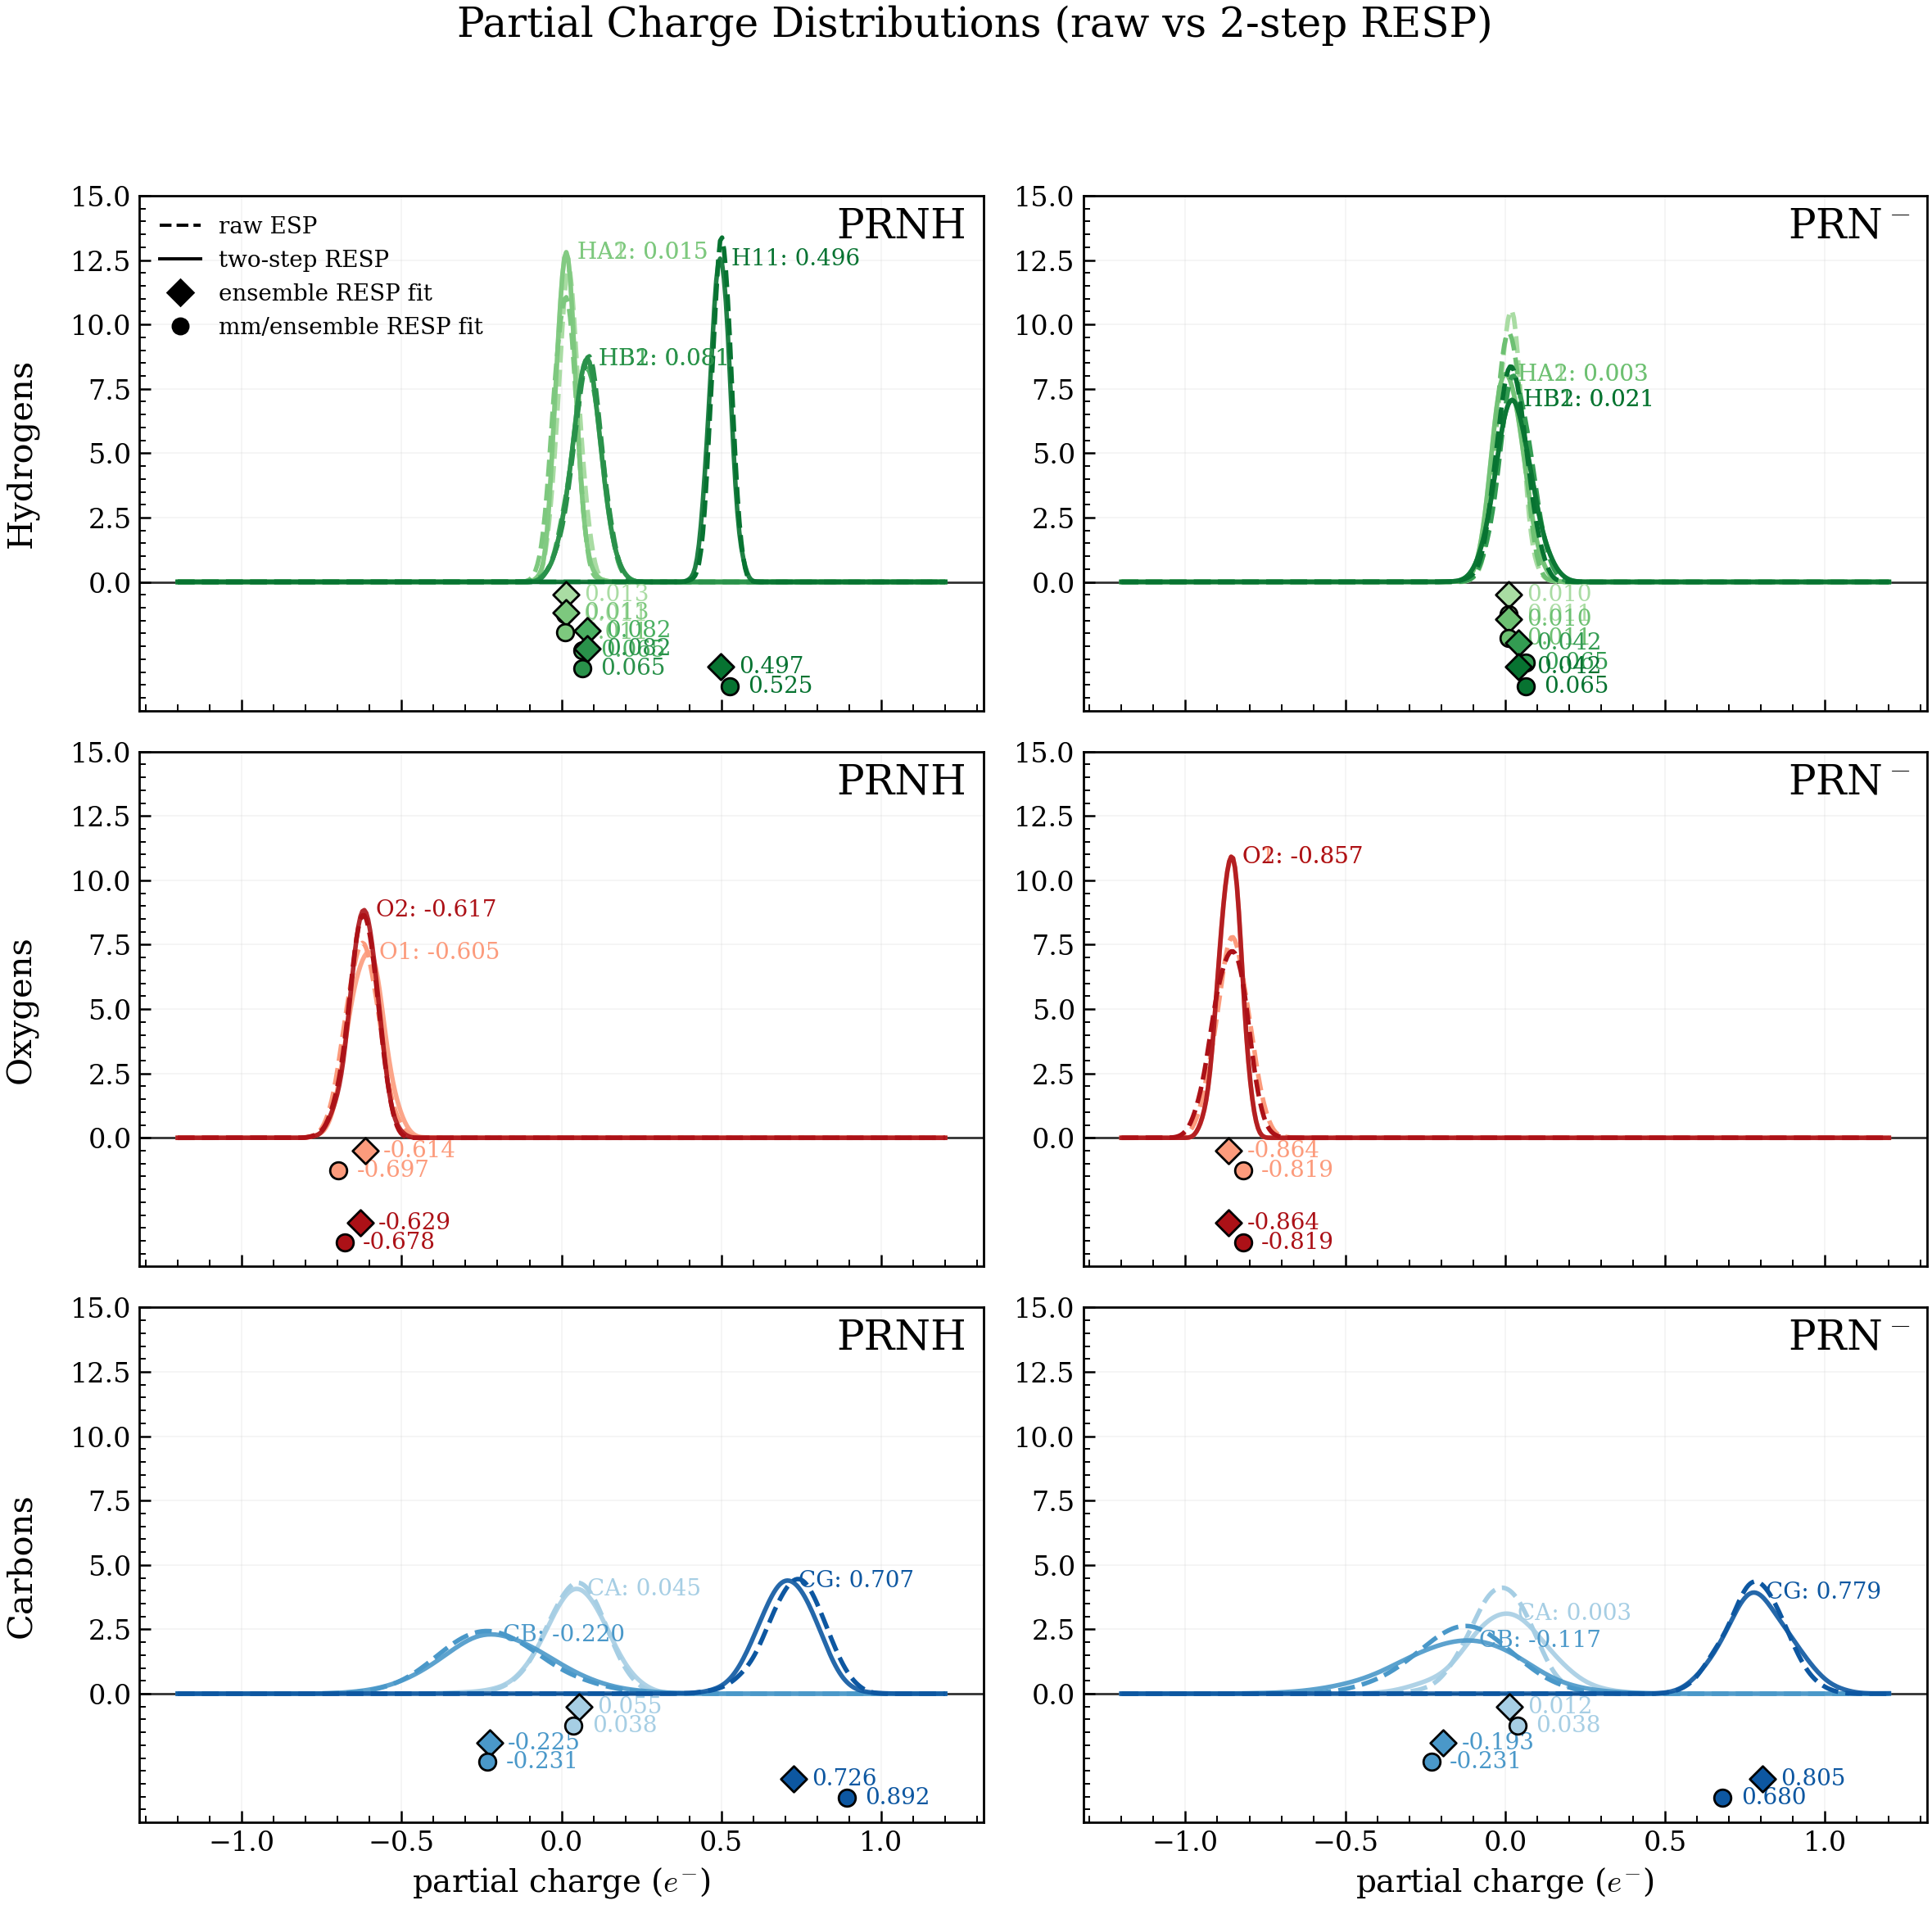

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=False)
axes = axes.reshape(3, 2)

bins   = np.linspace(-1.2, 1.2, 50)
x_grid = np.linspace(bins[0], bins[-1], 400)

element_datasets = [hydro_dataset, oxygen_dataset, carbon_dataset]
row_titles       = ["Hydrogens", "Oxygens", "Carbons"]

row_cmaps = {
    "Hydrogens": plt.cm.Greens,
    "Oxygens":   plt.cm.Reds,
    "Carbons":   plt.cm.Blues,
}

microstate_labels = ['PRNH', r'PRN$^-$']

for row, (edata, row_title) in enumerate(zip(element_datasets, row_titles)):
    cmap = row_cmaps[row_title]

    for col, state in enumerate(MICROSTATES):   # ["PRN_prot", "PRN_deprot"]
        ax = axes[row, col]

        # make enough vertical space for all offsets
        if row == 0:          # hydrogens
            ax.set_ylim(-5.0, 15)
        elif row == 1:        # oxygens
            ax.set_ylim(-5.0, 15)
        elif row == 2:        # carbons
            ax.set_ylim(-5.0, 15)

        labels         = edata[state]["labels"]
        raw_charges    = edata[state]["raw_charges"]      # (n_atoms, n_frames)
        tsresp         = edata[state]["tsresp_charges"]   # (n_atoms, n_frames)
        mccharges      = edata[state]["mcresp_charges"]   # (n_atoms,)
        mmresp_charges = edata[state]["mmresp_charges"]   # (n_atoms,)

        n_atoms = len(labels)
        if n_atoms == 0:
            ax.axis("off")
            continue

        colors = cmap(np.linspace(0.35, 0.85, n_atoms))

        # microstate label (top right)
        pretty_label = microstate_labels[col]
        ax.text(
            0.98, 0.98, pretty_label,
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=18,
        )

        # element label on left column
        if col == 0:
            ax.text(
                -0.12, 0.5, row_title,
                transform=ax.transAxes,
                ha="right", va="center",
                fontsize=15,
                rotation=90,
            )

        ax.grid(alpha=0.3)
        ax.set_xticks(np.arange(-1.5, 1.6, 0.5))
        ax.set_yticks([0] + list(ax.get_yticks()[ax.get_yticks() > 0]))
        ax.tick_params(axis="both", labelsize=12)
        ax.axhline(0, color="black", linewidth=1, alpha=0.8)

        # --- vertical offsets for markers to avoid overlap ---
        y_top_mc  = -0.5   # highest (closest to 0) mc diamond
        y_span_mc = 2.8    # total vertical span for mc diamonds
        if n_atoms > 1:
            dy_mc = y_span_mc / (n_atoms - 1)
        else:
            dy_mc = 0.0

        delta_mm = 0.75    # mm marker sits this much below its mc diamond

        # --- per-atom curves + markers ---
        for idx, (label, color) in enumerate(zip(labels, colors)):
            series_raw = raw_charges[idx]
            series_ts  = tsresp[idx]
            mc_val     = mccharges[idx]
            mm_val     = mmresp_charges[idx]

            # raw ESP KDE (dashed)
            kde_raw = gaussian_kde(series_raw)
            kde_raw.set_bandwidth(bw_method=kde_raw.factor * 1.75)
            density_raw = kde_raw(x_grid)

            ax.plot(
                x_grid,
                density_raw,
                color=color,
                linestyle="--",
                linewidth=2,
            )

            # two-step RESP KDE (solid)
            kde_ts = gaussian_kde(series_ts)
            kde_ts.set_bandwidth(bw_method=kde_ts.factor * 1.75)
            density_ts = kde_ts(x_grid)

            ax.plot(
                x_grid,
                density_ts,
                color=color,
                linestyle="-",
                linewidth=2,
                alpha=0.9,
            )

            # annotate at peak of the SOLID curve (two-step RESP)
            peak_idx = np.argmax(density_ts)
            x_peak   = x_grid[peak_idx]
            y_peak   = density_ts[peak_idx]

            ax.annotate(
                f"{label}: {x_peak:.3f}",
                xy=(x_peak, y_peak),
                xytext=(5, 0),
                textcoords="offset points",
                color=color,
                fontsize=10,
                ha="left",
                va="center",
            )

            # -------------------------------
            # offsets for this atom's markers
            # -------------------------------
            y_mc = y_top_mc - dy_mc * idx     # mc diamond y
            y_mm = y_mc - delta_mm            # mm marker just below

            # mcRESP: diamond + value
            ax.scatter(
                mc_val, y_mc,
                marker="D",
                s=65,
                color=color,
                edgecolor="k",
                zorder=6,
            )
            ax.annotate(
                f"{mc_val:.3f}",
                xy=(mc_val, y_mc),
                xytext=(8, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                fontsize=10,
                color=color,
            )

            # mmRESP: circle + value
            ax.scatter(
                mm_val, y_mm,
                marker="o",
                s=55,
                color=color,
                edgecolor="k",
                zorder=6,
            )
            ax.annotate(
                f"{mm_val:.3f}",
                xy=(mm_val, y_mm),
                xytext=(8, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                fontsize=10,
                color=color,
            )

        # x-label only on bottom row
        if row == 2:
            ax.set_xlabel(r"partial charge ($e^{-}$)", fontsize=14)

# line-style legend only (no atom legend; labels are on the curves)
axes[0, 0].plot([], [], "k--", label="raw ESP")
axes[0, 0].plot([], [], "k-" , label="two-step RESP")
axes[0, 0].plot([], [], marker="D", linestyle="", color="k",
                markersize=8, label="ensemble RESP fit")
axes[0, 0].plot([], [], marker="o", linestyle="", color="k",
                markersize=7, label="mm/ensemble RESP fit")
axes[0, 0].legend(frameon=False, fontsize=10, loc="upper left")

fig.suptitle(
    "Partial Charge Distributions (raw vs 2-step RESP)",
    fontsize=18,
)

fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig("../reports/PRN_HOC_grid.png", dpi=300)
#plt.show()


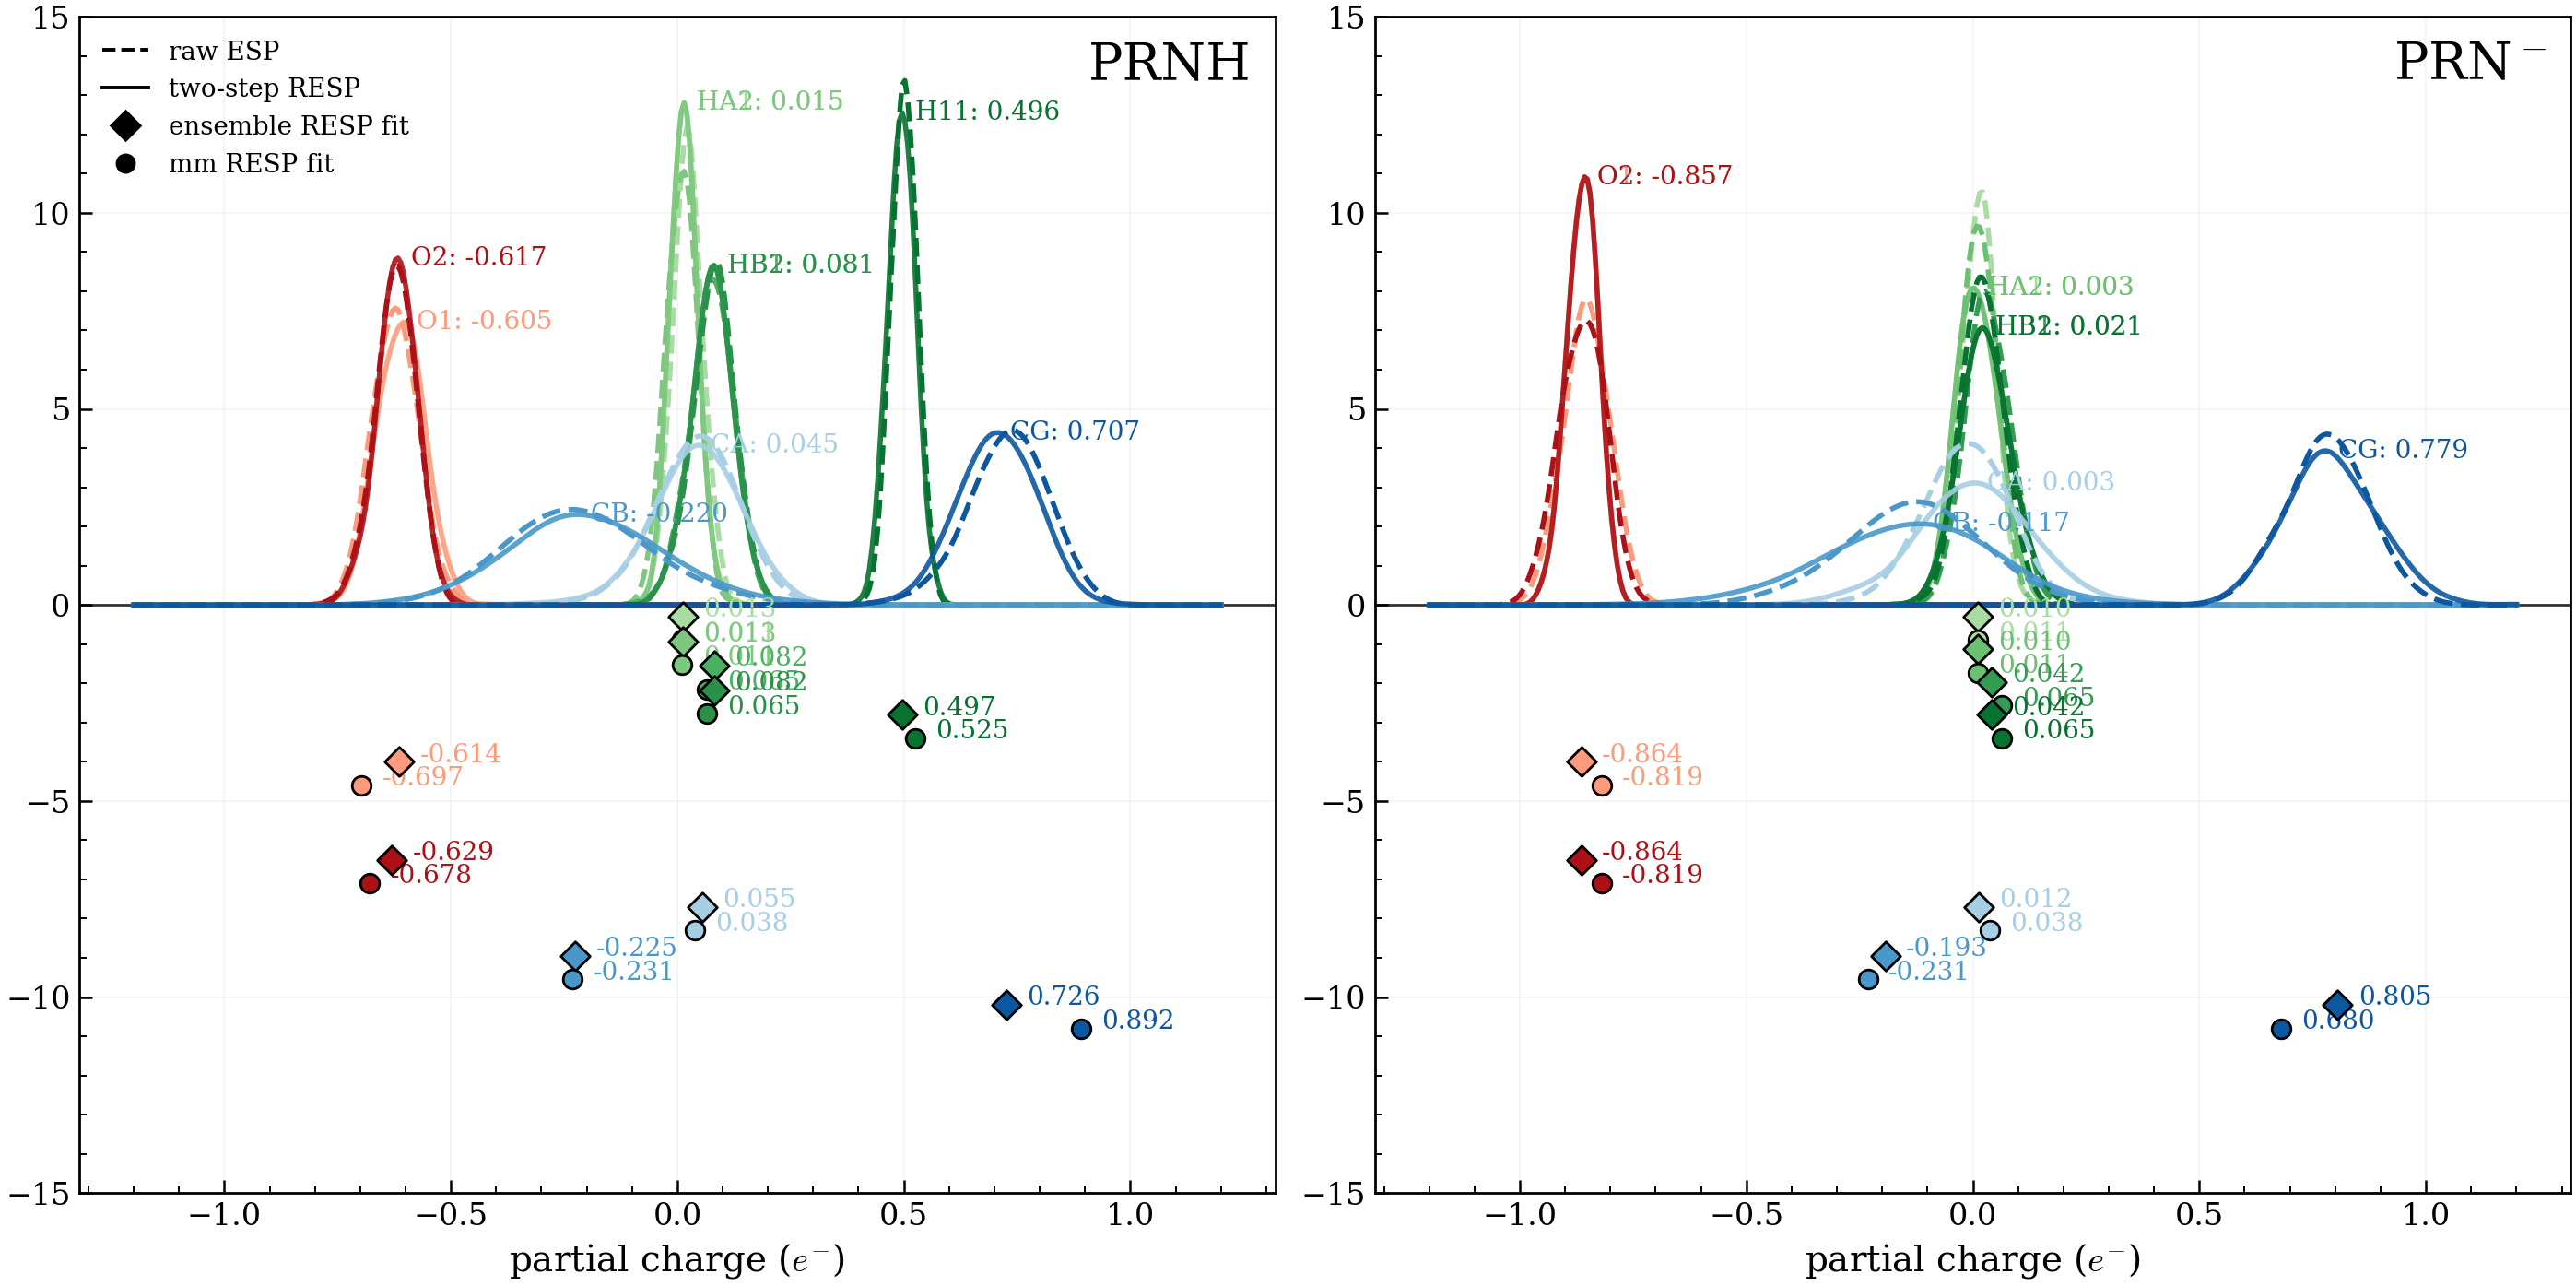

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=False)
axes = axes.reshape(1, 2)

bins   = np.linspace(-1.2, 1.2, 50)
x_grid = np.linspace(bins[0], bins[-1], 400)

combined = {
    "Hydrogens": hydro_dataset,
    "Oxygens":   oxygen_dataset,
    "Carbons":   carbon_dataset
}

row_cmaps = {
    "Hydrogens": plt.cm.Greens,
    "Oxygens":   plt.cm.Reds,
    "Carbons":   plt.cm.Blues,
}

microstate_labels = ['PRNH', r'PRN$^-$']

for col, state in enumerate(MICROSTATES):   # PRN_prot, PRN_deprot
    ax = axes[0, col]

    ax.set_ylim(-15.0, 15)
    ax.grid(alpha=0.3)

    # microstate title
    ax.text(0.98, 0.98, microstate_labels[col],
            transform=ax.transAxes,
            ha="right", va="top", fontsize=20)

    ax.set_xticks(np.arange(-1.5, 1.6, 0.5))
    ax.axhline(0, color="black", linewidth=1, alpha=0.8)
    ax.tick_params(axis="both", labelsize=12)

    # ---- vertical offsets
    y_top_mc  = -0.3      # highest mc diamond
    y_span_mc = 2.5       # span for each element group
    delta_mm  = 0.6       # mm is 0.6 below mc

    # use separate blocks for H, O, C
    offset_block = 0      # shifts each element down

    for element, dataset in combined.items():
        cmap = row_cmaps[element]

        labels         = dataset[state]["labels"]
        raw_charges    = dataset[state]["raw_charges"]
        tsresp         = dataset[state]["tsresp_charges"]
        mccharges      = dataset[state]["mcresp_charges"]
        mmresp_charges = dataset[state]["mmresp_charges"]

        n_atoms = len(labels)
        if n_atoms == 0:
            continue

        colors = cmap(np.linspace(0.35, 0.85, n_atoms))

        # element block offset
        block_top = y_top_mc - offset_block

        if n_atoms > 1:
            dy_mc = y_span_mc / (n_atoms - 1)
        else:
            dy_mc = 0.0

        # ---- per-atom plotting
        for idx, (label, color) in enumerate(zip(labels, colors)):
            series_raw = raw_charges[idx]
            series_ts  = tsresp[idx]
            mc_val     = mccharges[idx]
            mm_val     = mmresp_charges[idx]

            # RAW KDE = dashed
            kde_raw = gaussian_kde(series_raw)
            kde_raw.set_bandwidth(bw_method=kde_raw.factor * 1.75)
            density_raw = kde_raw(x_grid)
            ax.plot(x_grid, density_raw, color=color, linestyle="--", linewidth=2)

            # 2-STEP RESP KDE = solid
            kde_ts = gaussian_kde(series_ts)
            kde_ts.set_bandwidth(bw_method=kde_ts.factor * 1.75)
            density_ts = kde_ts(x_grid)
            ax.plot(x_grid, density_ts, color=color, linestyle="-", linewidth=2, alpha=0.9)

            # annotate at KDE peak (solid curve)
            peak_idx = np.argmax(density_ts)
            x_peak   = x_grid[peak_idx]
            y_peak   = density_ts[peak_idx]

            ax.annotate(f"{label}: {x_peak:.3f}",
                        xy=(x_peak, y_peak),
                        xytext=(5, 0),
                        textcoords="offset points",
                        color=color,
                        fontsize=10,
                        ha="left",
                        va="center")

            # ------- marker offsets -------
            y_mc = block_top - dy_mc * idx
            y_mm = y_mc - delta_mm

            # mcRESP diamond
            ax.scatter(mc_val, y_mc, marker="D", s=65, color=color,
                       edgecolor="k", zorder=6)
            ax.annotate(f"{mc_val:.3f}",
                        xy=(mc_val, y_mc),
                        xytext=(8, 0),
                        textcoords="offset points",
                        color=color,
                        fontsize=10,
                        ha="left")

            # mmRESP ring
            ax.scatter(mm_val, y_mm, marker="o", s=55, color=color,
                       edgecolor="k", zorder=6)
            ax.annotate(f"{mm_val:.3f}",
                        xy=(mm_val, y_mm),
                        xytext=(8, 0),
                        textcoords="offset points",
                        color=color,
                        fontsize=10,
                        ha="left")

        # shift to next element group
        offset_block += y_span_mc + 1.2

    # x-axis label at bottom
    ax.set_xlabel(r"partial charge ($e^{-}$)", fontsize=14)

# legends
axes[0, 0].plot([], [], "k--", label="raw ESP")
axes[0, 0].plot([], [], "k-" , label="two-step RESP")
axes[0, 0].plot([], [], marker="D", linestyle="", color="k", markersize=8,
                label="ensemble RESP fit")
axes[0, 0].plot([], [], marker="o", linestyle="", color="k", markersize=7,
                label="mm RESP fit")
axes[0, 0].legend(frameon=False, fontsize=10, loc="upper left")

#fig.suptitle("Combined Partial Charge Distributions (H + O + C)", fontsize=20)
plt.savefig('../reports/backbone-prn.png',dpi=300)
#plt.show()
